In [1]:
import pandas as pd
import numpy as np
import statistics
import matplotlib
from matplotlib import pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
import torch
import sklearn
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

In [2]:
data_path = 'z_ML datasets__/'

FreeSolve_df = pd.read_csv(data_path + 'SAMPL.csv')

FreeSolve_df.head(1)

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625


In [3]:
seed = 1

FreeSolve_df.sample(frac=.8, random_state = seed).head(3)

,iupac,smiles,expt,calc
179,"1,1,1-trimethoxyethane",CC(OC)(OC)OC,-4.42,-3.700
533,1-phenylethanone,CC(=O)c1ccccc1,-4.58,-5.078
526,methanethiol,CS,-1.20,-0.273


,iupac,smiles,expt,calc,ROMol,n_Atoms,Molec_weight,LogP,AP,HA,MaxCharge_abs,MaxCharge
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625,,13,179.219,1.397,1,0.076923,0.496768,0.252836

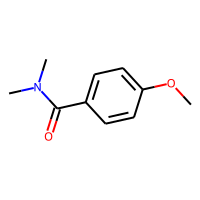

In [4]:
PandasTools.AddMoleculeColumnToFrame(FreeSolve_df, smilesCol='smiles')

FreeSolve_df['n_Atoms'] = FreeSolve_df['ROMol'].map(lambda x: x.GetNumAtoms())
 
FreeSolve_df['Molec_weight'] = [Descriptors.MolWt(mol) for mol in FreeSolve_df['ROMol']]

FreeSolve_df['LogP'] = [Chem.Crippen.MolLogP(mol) for mol in FreeSolve_df['ROMol']]

FreeSolve_df['AP'] = [Chem.rdMolDescriptors.CalcNumAromaticRings(mol) for mol in FreeSolve_df['ROMol']]

FreeSolve_df['HA'] = [Chem.rdMolDescriptors.CalcNumAromaticRings(mol) / mol.GetNumHeavyAtoms() for mol in FreeSolve_df['ROMol']]

FreeSolve_df['MaxCharge_abs'] = [Descriptors.MaxAbsPartialCharge(mol) for mol in FreeSolve_df['ROMol']]

FreeSolve_df['MaxCharge'] = [Descriptors.MaxPartialCharge(mol) for mol in FreeSolve_df['ROMol']]

#FreeSolve_df = FreeSolve_df.drop(['FP_1'], axis=1)

FreeSolve_df.head(1)

# Standart SMILES descriptors model

In [5]:
train_df_orig = FreeSolve_df.sample(frac=.8, random_state = seed)
test_df_orig = FreeSolve_df[~FreeSolve_df.index.isin(train_df_orig.index)]

print('Train set shape:', train_df_orig.shape, '\n', 'Test set shape:', test_df_orig.shape)

Train set shape: (514, 12) 
 Test set shape: (128, 12)


In [6]:
target = 'calc'

dim = 6

signs = ['MaxCharge_abs', 'MaxCharge', 'LogP', 'Molec_weight', 'HA', 'AP']

train_y_orig = np.asanyarray(train_df_orig[[target]]).astype(np.float32)
train_x_orig = np.asanyarray(train_df_orig[[signs[0],signs[1],signs[2],signs[3],signs[4],signs[5]]]).astype(np.float32)

train_x_orig = torch.from_numpy(train_x_orig.reshape(train_x_orig.shape[0], dim))
train_y_orig = torch.from_numpy(train_y_orig.reshape(train_y_orig.shape[0], 1))

test_y_orig = np.asanyarray(test_df_orig[[target]]).astype(np.float32)
test_x_orig = np.asanyarray(test_df_orig[[signs[0],signs[1],signs[2],signs[3],signs[4],signs[5]]]).astype(np.float32)

test_x_orig = torch.from_numpy(test_x_orig.reshape(test_x_orig.shape[0], dim))
test_y_orig = torch.from_numpy(test_y_orig.reshape(test_y_orig.shape[0], 1))

In [7]:
RF_Reg = RandomForestRegressor(random_state=seed)

RF_Reg.fit(train_x_orig, train_y_orig.numpy().ravel())

CV_RF = cross_validate(RF_Reg, train_x_orig, train_y_orig.numpy().ravel(), cv=5)

CV_RF['test_score'] = np.around(CV_RF['test_score'], 3)

print('Cross-val general:', round(np.mean(CV_RF['test_score']), 3))

RF_Reg = RF_Reg.predict(test_x_orig)

accuracy_RF = sklearn.metrics.r2_score(test_y_orig.detach().numpy(), RF_Reg) 

accuracy_RF=(round(accuracy_RF*100, 3))

print("Accuracy: %a"%accuracy_RF + "%") 

Cross-val general: 0.803
Accuracy: 87.17%


# Fingerprint dataframes with variable nBits

In [8]:
FP_512 = [];    FP_1024 = [];    FP_2048 = [];    FP_4096 = []

FP_list = [FP_512, FP_1024, FP_2048, FP_4096]

nBits = [512, 1024, 2048, 4096]

s_rad = 2

for i in range(len(FreeSolve_df['ROMol'])):
    
    mol512 = AllChem.GetMorganFingerprintAsBitVect(FreeSolve_df['ROMol'][i], s_rad, nBits=512)
    
    mol1024 = AllChem.GetMorganFingerprintAsBitVect(FreeSolve_df['ROMol'][i], s_rad, nBits=1024)
    
    mol2048 = AllChem.GetMorganFingerprintAsBitVect(FreeSolve_df['ROMol'][i], s_rad, nBits=2048)
    
    mol4096 = AllChem.GetMorganFingerprintAsBitVect(FreeSolve_df['ROMol'][i], s_rad, nBits=4096)
    
    FP_list[0].append(mol512)
    
    FP_list[1].append(mol1024)
    
    FP_list[2].append(mol2048)
    
    FP_list[3].append(mol4096)

In [9]:
df_y = pd.DataFrame(np.asanyarray(FreeSolve_df['calc']))


train_y = df_y.sample(frac=.8, random_state = seed)

test_y = df_y[~df_y.index.isin(train_y.index)]


FP_df512 = pd.DataFrame(np.asanyarray(FP_512))

train_x512 = FP_df512.sample(frac=.8, random_state = seed)

test_x512 = FP_df512[~FP_df512.index.isin(train_x512.index)]


FP_df1024 = pd.DataFrame(np.asanyarray(FP_1024))

train_x1024 = FP_df1024.sample(frac=.8, random_state = seed)

test_x1024 = FP_df1024[~FP_df1024.index.isin(train_x1024.index)]


FP_df2048 = pd.DataFrame(np.asanyarray(FP_2048))

train_x2048 = FP_df2048.sample(frac=.8, random_state = seed)

test_x2048 = FP_df2048[~FP_df2048.index.isin(train_x2048.index)]


FP_df4096 = pd.DataFrame(np.asanyarray(FP_4096))

train_x4096 = FP_df4096.sample(frac=.8, random_state = seed)

test_x4096 = FP_df4096[~FP_df4096.index.isin(train_x4096.index)]

# PCA construction

In [10]:
FP_df_list = [FP_df512, FP_df1024, FP_df2048, FP_df4096]

#PCA has limits of offered bits (<= df.shape[0])

n_com_list_512 = [32, 8, 6]

n_com_list_1024 = [64, 16, 6]

n_com_list_2048 = [128, 32, 6]

n_com_list_4096 = [256, 64, 6]

general_n_list = [n_com_list_512, n_com_list_1024, n_com_list_2048, n_com_list_4096]

accuracy_list = []

CV_list = []

CV_std_list = []

In [11]:
def dimensionality_reduction(n_components_list, FP_df_list_index, accuracy_list, CV_list):

    for i in range(len(n_components_list)):
    
        print("Reduction to %a"%n_components_list[i] + " bits") 
    
        pca_reducted = PCA(n_components = n_components_list[i])

        FP_df_reducted =  pd.DataFrame(pca_reducted.fit_transform(FP_df_list_index))

        train_x_reducted = FP_df_reducted.sample(frac=.8, random_state = seed)

        test_x_reducted = FP_df_reducted[~FP_df_reducted.index.isin(train_x_reducted.index)]
    
        RF_Reg_reducted = RandomForestRegressor(random_state=seed)

        RF_Reg_reducted.fit(train_x_reducted, train_y[0])

        CV_RF_reducted = cross_validate(RF_Reg_reducted, train_x_reducted, train_y[0], cv=5)
        
        CV_std_list.append(round(np.std(CV_RF_reducted['test_score']), 3))
    
        CV_RF_reducted['test_score'] = np.around(CV_RF_reducted['test_score'], 3)
        
        CV_RF_reducted = round(np.mean(CV_RF_reducted['test_score']), 3)
      
        print('Cross-val general:', CV_RF_reducted)
    
        RF_Reg_reducted = RF_Reg_reducted.predict(test_x_reducted)

        accuracy_RF_reducted = sklearn.metrics.r2_score(test_y[0], RF_Reg_reducted) 

        accuracy_RF_reducted = (round(accuracy_RF_reducted*100, 3))
        
        accuracy_list.append(accuracy_RF_reducted)
  
        CV_list.append(CV_RF_reducted)

        print("Accuracy: %a"%accuracy_RF_reducted + "%" + "\n") 

# Fingerprints dataframes applied to Random Forest 

512 bits

In [12]:
RF_Reg512 = RandomForestRegressor(random_state=seed)

RF_Reg512.fit(train_x512, train_y[0])

CV_RF_512 = cross_validate(RF_Reg512, train_x512, train_y[0], cv=5)

CV_std_list.append(round(np.std(CV_RF_512['test_score']), 3))
    
CV_RF_512['test_score'] = np.around(CV_RF_512['test_score'], 3)

CV_RF_512 = round(np.mean(CV_RF_512['test_score']), 3)
      
print('Cross-val general:', CV_RF_512)
    
RF_Reg512 = RF_Reg512.predict(test_x512)

accuracy_RF_512 = sklearn.metrics.r2_score(test_y[0], RF_Reg512) 

accuracy_RF_512 = (round(accuracy_RF_512*100, 3))

accuracy_list.append(accuracy_RF_512)

CV_list.append(CV_RF_512)

print("Accuracy: %a"%accuracy_RF_512 + "%" + "\n") 

Cross-val general: 0.731
Accuracy: 69.51%



In [13]:
dimensionality_reduction(general_n_list[0], FP_df_list[0], accuracy_list, CV_list)

print("-------------------------------------")

Reduction to 32 bits
Cross-val general: 0.606
Accuracy: 67.005%

Reduction to 8 bits
Cross-val general: 0.466
Accuracy: 63.855%

Reduction to 6 bits
Cross-val general: 0.453
Accuracy: 61.844%

-------------------------------------


1024 bits

In [14]:
RF_Reg1024 = RandomForestRegressor(random_state=seed)

RF_Reg1024.fit(train_x1024, train_y[0])

CV_RF_1024 = cross_validate(RF_Reg1024, train_x1024, train_y[0], cv=5)

CV_std_list.append(round(np.std(CV_RF_1024['test_score']), 3))
    
CV_RF_1024['test_score'] = np.around(CV_RF_1024['test_score'], 3)

CV_RF_1024 = round(np.mean(CV_RF_1024['test_score']), 3)
    
print('Cross-val general:', CV_RF_1024)
    
RF_Reg1024 = RF_Reg1024.predict(test_x1024)

accuracy_RF_1024 = sklearn.metrics.r2_score(test_y[0], RF_Reg1024) 

accuracy_RF_1024 = (round(accuracy_RF_1024*100, 3))

accuracy_list.append(accuracy_RF_1024)

CV_list.append(CV_RF_1024)

print("Accuracy: %a"%accuracy_RF_1024 + "%" + "\n") 

Cross-val general: 0.733
Accuracy: 69.643%



In [15]:
dimensionality_reduction(general_n_list[1], FP_df_list[1], accuracy_list, CV_list)

print("-------------------------------------")

Reduction to 64 bits
Cross-val general: 0.657
Accuracy: 70.999%

Reduction to 16 bits
Cross-val general: 0.612
Accuracy: 67.054%

Reduction to 6 bits
Cross-val general: 0.509
Accuracy: 55.659%

-------------------------------------


2048 bits

In [16]:
RF_Reg2048 = RandomForestRegressor(random_state=seed)

RF_Reg2048.fit(train_x2048, train_y[0])

CV_RF_2048 = cross_validate(RF_Reg2048, train_x2048, train_y[0], cv=5)

CV_std_list.append(round(np.std(CV_RF_2048['test_score']), 3))
    
CV_RF_2048['test_score'] = np.around(CV_RF_2048['test_score'], 3)
    
CV_RF_2048 = round(np.mean(CV_RF_2048['test_score']), 3)
    
print('Cross-val general:', CV_RF_2048)
    
RF_Reg2048 = RF_Reg2048.predict(test_x2048)

accuracy_RF_2048 = sklearn.metrics.r2_score(test_y[0], RF_Reg2048) 

accuracy_RF_2048 = (round(accuracy_RF_2048*100, 3))

accuracy_list.append(accuracy_RF_2048)

CV_list.append(CV_RF_2048)

print("Accuracy: %a"%accuracy_RF_2048 + "%" + "\n") 

Cross-val general: 0.725
Accuracy: 71.624%



In [17]:
dimensionality_reduction(general_n_list[2], FP_df_list[2], accuracy_list, CV_list)

print("-------------------------------------")

Reduction to 128 bits
Cross-val general: 0.592
Accuracy: 67.86%

Reduction to 32 bits
Cross-val general: 0.673
Accuracy: 71.243%

Reduction to 6 bits
Cross-val general: 0.471
Accuracy: 58.941%

-------------------------------------


4096 bits

In [18]:
RF_Reg4096 = RandomForestRegressor(random_state=seed)

RF_Reg4096.fit(train_x4096, train_y[0])

CV_RF_4096 = cross_validate(RF_Reg4096, train_x4096, train_y[0], cv=5)

CV_std_list.append(round(np.std(CV_RF_4096['test_score']), 3))
    
CV_RF_4096['test_score'] = np.around(CV_RF_4096['test_score'], 3)

CV_RF_4096 = round(np.mean(CV_RF_4096['test_score']), 3)
    
print('Cross-val general:', CV_RF_4096)
    
RF_Reg4096 = RF_Reg4096.predict(test_x4096)

accuracy_RF_4096 = sklearn.metrics.r2_score(test_y[0], RF_Reg4096) 

accuracy_RF_4096 = (round(accuracy_RF_4096*100, 3))

accuracy_list.append(accuracy_RF_4096)

CV_list.append(CV_RF_4096)

print("Accuracy: %a"%accuracy_RF_4096 + "%" + "\n")

Cross-val general: 0.748
Accuracy: 73.48%



In [19]:
dimensionality_reduction(general_n_list[3], FP_df_list[3], accuracy_list, CV_list)

print("-------------------------------------")

Reduction to 256 bits
Cross-val general: 0.605
Accuracy: 63.58%

Reduction to 64 bits
Cross-val general: 0.663
Accuracy: 67.334%

Reduction to 6 bits
Cross-val general: 0.448
Accuracy: 58.411%

-------------------------------------


# Comparison

- The last number bits for reduction (= 6) serve as the measure between fingerprints features model and model with 6 features got from smiles ("Standart SMILES descriptors model" section)

In [20]:
types_RF_list = [
                 'RF 512 (standart)', 'RF 512 (to %a'%(n_com_list_512[0])+' bits)', 'RF 512 (to %a'%(n_com_list_512[1])+' bits)', 'RF 512 (to %a'%(n_com_list_512[2])+' bits)',
                 'RF 1024 (standart)', 'RF 1024 (to %a'%(n_com_list_1024[0])+' bits)', 'RF 1024 (to %a'%(n_com_list_1024[1])+' bits)', 'RF 1024 (to %a'%(n_com_list_1024[2])+' bits)',
                 'RF 2048 (standart)', 'RF 2048 (to %a'%(n_com_list_2048[0])+' bits)', 'RF 2048 (to %a'%(n_com_list_2048[1])+' bits)', 'RF 2048 (to %a'%(n_com_list_2048[2])+' bits)',
                 'RF 4096 (standart)', 'RF 4096 (to %a'%(n_com_list_4096[0])+' bits)', 'RF 4096 (to %a'%(n_com_list_4096[1])+' bits)', 'RF 4096 (to %a'%(n_com_list_4096[2])+' bits)'
                 ]

CV_RF_list = [CV_RF_512, CV_RF_1024, CV_RF_2048, CV_RF_4096]

- Because of cyclical way of saving the values (Accuracy, CV_score, CV_std), all models must be strictly launched one after another (according the order of their enumerating and writing) to make the results displaying correct

In [21]:
rfscore_df = pd.DataFrame()

atr = 'test_score'

rfscore_df["Regression type"] =  [types_RF_list[i] for i in range(len(types_RF_list))]

rfscore_df["Accuracy, %"] = [accuracy_list[i] for i in range(len(accuracy_list))]

rfscore_df["CV_score"] = [CV_list[i] for i in range(len(CV_list))]

rfscore_df["CV_std"] = [CV_std_list[i] for i in range(len(CV_std_list))]

#rfscore_df["CV_score_general"] = [np.mean(CV[atr][:]) for CV in CV_RF_list]

rfscore_df

,Regression type,"Accuracy, %",CV_score,CV_std
0,RF 512 (standart),69.510,0.731,0.041
1,RF 512 (to 32 bits),67.005,0.606,0.060
2,RF 512 (to 8 bits),63.855,0.466,0.041
3,RF 512 (to 6 bits),61.844,0.453,0.052
4,RF 1024 (standart),69.643,0.733,0.038
5,RF 1024 (to 64 bits),70.999,0.657,0.036
6,RF 1024 (to 16 bits),67.054,0.612,0.060
7,RF 1024 (to 6 bits),55.659,0.509,0.052
8,RF 2048 (standart),71.624,0.725,0.038
9,RF 2048 (to 128 bits),67.860,0.592,0.061
